# MAKE DATA

In [1]:
import os
import random
import pickle
import json
from datetime import datetime
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from huggingface_hub import HfApi, snapshot_download
from PIL import Image
from tqdm.notebook import tqdm

In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  
seed = 42
seed_everything(42)

In [4]:
def mk_dir(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)
    
def get_timestamp(date_format: str = '%d%H%M%S') -> str:
    timestamp = datetime.now()
    return timestamp.strftime(date_format)

data_dir = "./data/sequential/small"
mk_dir(data_dir)

In [5]:
def dump_pickle(data, path):
    with open(path, "wb") as file:
        pickle.dump(data, file)

def load_pickle(path):
    with open(path, "rb") as file:
        data = pickle.load(file)
    return data

def dump_json(data, path):
    with open(path, "w") as file:
        json.dump(data, file)

def load_json(path):
    with open(path, "r") as file:
        data = json.load(file)
    return data

def save_pt(data, path):
    with open(path, "wb") as file:
        torch.save(data, file)

#### 데이터 load 및 shape 확인

In [6]:
item_data = pd.read_csv("./data/origin/articles.csv")
interaction_data = pd.read_csv("./data/origin/transactions_train.csv")

In [7]:
is_equal = interaction_data.equals(interaction_data.sort_values(by=['t_dat','customer_id'], axis=0).reset_index(drop=True))
print(f"날짜 및 사용자 기준으로 정렬된 것과 기존 데이터가 같은가? : {is_equal}") 
# 정렬 필요하지 않음

날짜 및 사용자 기준으로 정렬된 것과 기존 데이터가 같은가? : True


In [8]:
# 다량 구매 하나로 줄이기
drop_idx = []

for idx in tqdm(range(1,len(interaction_data))):
    if interaction_data.iloc[idx-1].equals(interaction_data.iloc[idx]):
        drop_idx.append(idx)

interaction_data = interaction_data.drop(index=drop_idx).reset_index(drop=True)

  0%|          | 0/31788323 [00:00<?, ?it/s]

In [9]:
# 결측치 포함된 행 drop
n_item_data = item_data.dropna(axis=0, how="any").reset_index(drop=True)

In [10]:
print("shape of Item data : ",n_item_data.shape)
print("shape of interaction data : ", interaction_data.shape)

shape of Item data :  (105126, 25)
shape of interaction data :  (28839228, 5)


#### 이미지가 없는 아이템 찾기

In [14]:
def img_by_id(df, article_id:int, no_list:list, echo:int=1, img_show:bool=True):
    if article_id in no_list:
        return
    if echo:
        display(df[df.article_id == article_id])

    img_id = "0"+str(article_id)
    img = Image.open("./data/origin/images/"+img_id[0:3]+"/"+img_id+".jpg")

    if img_show:
        img.show()

def find_no_img_item(df):
    no_img = []

    for item in tqdm(df.iterrows(), total=len(df)):
        try:
            img_by_id(df, item[1][0], no_list=no_img, echo=0, img_show=False)
        except FileNotFoundError:
            no_img.append(item[0])

    return no_img

In [15]:
no_img_idx = find_no_img_item(item_data)

  0%|          | 0/105542 [00:00<?, ?it/s]

C:\Users\손봉국\AppData\Local\Temp\ipykernel_8224\73078676.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_by_id(df, item[1][0], no_list=no_img, echo=0, img_show=False)


In [16]:
print("# of non-img item : ",len(no_img_idx))

# of non-img item :  442


In [17]:
# 이미지가 없는 아이템 삭제
no_img_item = {idx:item_data.iloc[idx].article_id for idx in no_img_idx}
n_item_data = item_data.drop(no_img_idx, axis=0).reset_index(drop=True) # 이미지 없는 아이템을 삭제한 데이터
print("shape of n_item_data : ", n_item_data.shape)

shape of n_item_data :  (105100, 25)


#### 상품 카테고리(product_type_no)에 따른 필터링

In [18]:
# product_type에 속하는 상품이 10개 미만인 경우 삭제 131 -> 94로 줄어듦, 아이템은 약 130개 사라짐
n_item_data = n_item_data.groupby('product_type_no').filter(lambda x: len(x) >= 10).reset_index(drop=True)
print("shape of n_item_data : ", n_item_data.shape)

shape of n_item_data :  (104973, 25)


In [19]:
# product_type 중 불필요한 것 삭제 -> 84로 줄어듧, 아이템 400개 정도 사라짐
rm_list = ["Umbrella", "Bracelet", "Giftbox", "Waterbottle", 
           "Nipple covers", 'Chem. cosmetics', "Fine cosmetics", "Soft Toys",
           "Bra extender", "Cushion", "Side table", "Dog Wear", "Keychain",
           "Sewing kit", "Towel", "Mobile case", "Zipper head",
           "Wireless earphone case", "Stain remover spray",
           "Clothing mist", "Hair ties"]
n_item_data = n_item_data[~n_item_data['product_type_name'].isin(rm_list)].reset_index(drop=True)
print("shape of n_item_data : ", n_item_data.shape)
print("# of product_type : ", n_item_data.product_type_name.nunique())


shape of n_item_data :  (104572, 25)
# of product_type :  84


In [20]:
# interacion data에서 앞선 과정에서 삭제된 데이터 제거
n_interaction_data = interaction_data[interaction_data['article_id'].isin(n_item_data['article_id'])].reset_index(drop=True)
print("shape of interaction data : ", interaction_data.shape)
print("shape of n_interaction_data : ", n_interaction_data.shape)

shape of interaction data :  (28839228, 5)
shape of n_interaction_data :  (28622541, 5)


#### 구매이력

In [21]:
cnt_ = n_interaction_data.groupby(["customer_id"]).article_id.count()

In [22]:
pd.options.display.float_format = '{:.5f}'.format

In [23]:
cnt_.describe()

count   1361131.00000
mean         21.02850
std          34.41201
min           1.00000
25%           3.00000
50%           9.00000
75%          24.00000
max        1636.00000
Name: article_id, dtype: float64

In [24]:
unique, counts = np.unique(cnt_, return_counts=True)

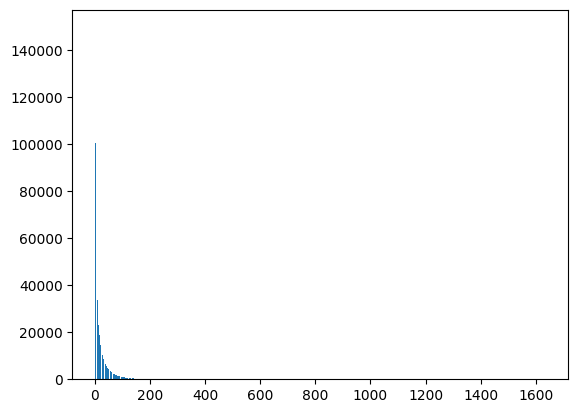

In [25]:
import matplotlib.pyplot as plt

# 구매 횟수에 대한 빈도 막대 그래프
plt.bar(unique, counts)
# plt.xlim((0,200))
# plt.ylim((0,500))
plt.show()

#### 아이템 및 유저의 상호작용 수에 따른 데이터 처리

In [26]:
n_item_data = n_item_data[["article_id","product_type_no"]]

In [27]:
# 아이템/유저 등장 빈도에 따른 데이터 구성
# 유저: 상호작용이 threshold 이하인 경우 삭제, 아이템 : 상호작용이 20 이하인 경우 삭제 
# 상호작용 유저/아이템 수는 반복 구매를 제외하고 unique한 값을 기준으로 함
# 반복적으로 실행하여, 모든 유저, 아이템이 조건을 만족하도록 함

def data_cutter(origin_data, threshold=20):
    while True:
        new_data = origin_data.groupby('customer_id').filter(lambda x: x.article_id.nunique() >= threshold).reset_index(drop=True)
        new_data = new_data.groupby('article_id').filter(lambda x: x.customer_id.nunique() >= 20).reset_index(drop=True)
        
        if new_data.equals(origin_data):
            print("finish")
            break
        origin_data = new_data
        print("cut again")

    print("shape of n_interaction_data : ", new_data.shape)
    print("num of user : ", new_data.customer_id.nunique())
    print("num of item : ", new_data.article_id.nunique())
    print("data density : ", new_data.shape[0]/(new_data.customer_id.nunique()*new_data.article_id.nunique())*100, "%")
    
    return new_data

In [28]:
# n_interaction_data_10 = data_cutter(n_interaction_data, 10)
# n_interaction_data_20 = data_cutter(n_interaction_data, 20)
new_interaction_data = data_cutter(n_interaction_data, 40) # 아이템: 20미만 삭제, 유저: 40미만 삭제

cut again
cut again
cut again
cut again
finish
shape of n_interaction_data :  (15984824, 5)
num of user :  190977
num of item :  60286
data density :  0.13883863102382377 %


In [29]:
n_item_data = n_item_data[n_item_data['article_id'].isin(new_interaction_data['article_id'])].reset_index(drop=True)

In [30]:
# product_type마다 속하는 item 목록 생성 {product_type_no : [items]}
items_by_prod_type = dict(list(n_item_data.groupby("product_type_no")))
for k in items_by_prod_type.keys():
    items_by_prod_type[k] = items_by_prod_type[k].article_id.reset_index(drop=True).tolist()

In [31]:
# prod_type에 속하는 아이템이 5개 미만인 경우 prod_type과 그에 속하는 아이템 삭제
rm_list = [key for key, value in items_by_prod_type.items() if len(value) < 5]

for k in rm_list:
    del items_by_prod_type[k]
    
n_item_data = n_item_data[~n_item_data['product_type_no'].isin(rm_list)].reset_index(drop=True)

In [32]:
new_interaction_data = new_interaction_data[new_interaction_data['article_id'].isin(n_item_data['article_id'])].reset_index(drop=True)

In [33]:
print("shape of n_item_data : ", n_item_data.shape)
print("shape of new_interaction_data : ", new_interaction_data.shape)

shape of n_item_data :  (60285, 2)
shape of new_interaction_data :  (15984802, 5)


In [34]:
metadata = {"shape of interaction data" : new_interaction_data.shape,
            "num of user" : new_interaction_data.customer_id.nunique(),
            "num of item" : new_interaction_data.article_id.nunique(),
            "data density" : f'{new_interaction_data.shape[0]/(new_interaction_data.customer_id.nunique()*new_interaction_data.article_id.nunique())*100}%'}
dump_json(metadata, f'{data_dir}/metadata.json')

In [35]:
# product_type마다 속하는 item 목록 생성 {product_type_no : [items]}
items_by_prod_type = dict(list(n_item_data.groupby("product_type_no")))
for k in items_by_prod_type.keys():
    items_by_prod_type[k] = items_by_prod_type[k].article_id.reset_index(drop=True).tolist()

torch.save(items_by_prod_type, f"{data_dir}/items_by_prod_type.pt")

#### 아이템 이미지 임베딩 생성 with fashion clip

In [37]:
from fashion_clip.fashion_clip import FashionCLIP
fclip = FashionCLIP('fashion-clip')

images = ["./data/origin/images/" + "0" + str(k)[0:2] + "/" + "0"+str(k) + ".jpg" for k in n_item_data["article_id"].tolist()]
image_embeddings = fclip.encode_images(images, batch_size=1024)

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

59it [26:09, 26.61s/it]                        


In [38]:
# {article_id : emb}
id_emb_map = {k:torch.tensor(v) for k,v in zip(n_item_data["article_id"].tolist(), image_embeddings)}
torch.save(id_emb_map, f'{data_dir}/aritcle_id_img_emb.pt')

In [46]:
#이미지 임베딩을 pkl/json 파일로 저장하고 싶은 경우 실행
dump_pickle(image_embeddings, f'{data_dir}/img_emb_small.pkl')
# dump_json(image_embeddings, f'{data_dir}/img_emb_small.json')

#### id mapping

In [39]:
user2idx = {v:k for k,v in enumerate(new_interaction_data['customer_id'].unique())} # {user_id:idx}
item2idx = {v:k for k,v in enumerate(n_item_data['article_id'].unique())}         # {item_id:idx}

print("# of user", len(user2idx))
print("# of item", len(item2idx))

torch.save(item2idx, f'{data_dir}/item2idx.pt')

# of user 190977
# of item 60285


In [41]:
item_idx_img_emb=  {v: id_emb_map[k] for k,v in item2idx.items()}

In [42]:
torch.save(item_idx_img_emb, f'{data_dir}/item_idx_img_emb.pt')

In [43]:
new_interaction_data["customer_id"] = new_interaction_data["customer_id"].map(user2idx)
new_interaction_data["article_id"] = new_interaction_data["article_id"].map(item2idx)
n_item_data["article_id"] = n_item_data["article_id"].map(item2idx)

In [44]:
#{article_id: product_type_no}
item_with_prod_type = {k:v for k,v in zip(n_item_data.article_id, n_item_data.product_type_no)}
torch.save(item_with_prod_type, f'{data_dir}/article_id_product_type_no.pt')

#### train/valid/test split

In [45]:
new_interaction_data = new_interaction_data.drop(["t_dat", "price","sales_channel_id"], axis=1)
unique_data = new_interaction_data.drop_duplicates(["article_id", "customer_id"])

random split

In [46]:
test_data = unique_data.groupby("customer_id").sample(n=1, random_state=seed) # 랜덤하게 1개 추출하여 test로 사용
unique_data = unique_data[~unique_data.index.isin(test_data.index)] # test set으로 추출된 것 제거
valid_data = unique_data.groupby("customer_id").sample(n=1, random_state=seed) # 다시 랜덤하게 1개 추출하여 valid로 사용

print(f'test 및 valid가 중복없이 생성되었는가? : {pd.concat([valid_data, test_data]).drop_duplicates(keep=False).shape[0] == (valid_data.shape[0] + test_data.shape[0])}')

test 및 valid가 중복없이 생성되었는가? : True


split by time

In [47]:
test_data = unique_data.groupby("customer_id").nth(-1) # 랜덤하게 1개 추출하여 test로 사용
valid_data = unique_data.groupby("customer_id").nth(-2) # 다시 랜덤하게 1개 추출하여 valid로 사용

print(f'test 및 valid가 중복없이 생성되었는가? : {pd.concat([valid_data, test_data]).drop_duplicates(keep=False).shape[0] == (valid_data.shape[0] + test_data.shape[0])}')

test 및 valid가 중복없이 생성되었는가? : True


split by time (unused item case)

In [49]:
test_data = unique_data.groupby("customer_id").nth(-1).reset_index() #가장 마지막 1개 추출
user_item_dict = dict(list(new_interaction_data.groupby("customer_id")))

for idx, row in tqdm(test_data.iterrows(), total=len(test_data)):
    i = -1
    item = row.article_id
    user = row.customer_id
    
    while sum(user_item_dict[user].article_id.isin([item])) > 1: #구매 이력에 1번 이상 존재하는 경우 그 앞의 것 확인
        i -= 1
        item = user_item_dict[user].article_id.iloc[i]
        # print(f"{idx, user} Again")
    
    test_data.at[idx, 'article_id'] = item

  0%|          | 0/190977 [00:00<?, ?it/s]

In [50]:
# 값이 변경됐는지 확인
print(test_data.iloc[50])
print(unique_data.groupby("customer_id").nth(-1).reset_index().iloc[50])

index          2325131
customer_id     162082
article_id        3174
Name: 50, dtype: int64
index          2325131
customer_id     162082
article_id        3174
Name: 50, dtype: int64


In [51]:
unique_data = unique_data[~unique_data.index.isin(test_data["index"])] # test set으로 추출된 것 제거

In [52]:
valid_data = unique_data.groupby("customer_id").nth(-1).reset_index() # 가장 마지막 1개 추출 -> test를 제외하였으므로 -2번째로 볼 수 있음

for idx, row in tqdm(valid_data.iterrows(), total=len(valid_data)):
    i = -1
    item = row.article_id
    user = row.customer_id
    
    while sum(user_item_dict[user].article_id.isin([item])) > 1: #구매 이력에 1번 이상 존재하는 경우 제외
        i -= 1
        item = user_item_dict[user].article_id.iloc[i]
        # print(f"{idx, user} Again")
    
    valid_data.at[idx, 'article_id'] = item

  0%|          | 0/190977 [00:00<?, ?it/s]

In [53]:
# 값이 변경됐는지 확인
print(valid_data.iloc[199])
print(unique_data.groupby("customer_id").nth(-2).reset_index().iloc[199])

index          3661442
customer_id     151871
article_id       25328
Name: 199, dtype: int64
index          3498184
customer_id     117085
article_id       31396
Name: 199, dtype: int64


In [54]:
print(f'test 및 valid가 중복없이 생성되었는가? : {pd.concat([valid_data, test_data]).drop_duplicates(keep=False).shape[0] == (valid_data.shape[0] + test_data.shape[0])}')

test 및 valid가 중복없이 생성되었는가? : True


test/valid로 선정된 것 train에서 제거

In [55]:
drop_index = pd.Index([None])

for key, data in tqdm(new_interaction_data.groupby("customer_id"), total=new_interaction_data.customer_id.nunique()):
    valid_item = valid_data[valid_data.customer_id==key].article_id
    test_item = test_data[test_data.customer_id==key].article_id
    idxs = data[data.article_id.isin(np.concatenate((valid_item, test_item)))].index
    if len(idxs) > 2: # 검증용
        print(key)
    drop_index = drop_index.append(idxs)

  0%|          | 0/190977 [00:00<?, ?it/s]

In [56]:
drop_index = drop_index.dropna() # remove None
train_data = new_interaction_data.drop(index=drop_index) 

test_data = test_data.reset_index(drop=True).drop(columns="index")
valid_data = valid_data.reset_index(drop=True).drop(columns="index")
train_data = train_data.reset_index(drop=True)

valid_data = valid_data.sort_values(by="customer_id").reset_index(drop=True)
test_data = test_data.sort_values(by="customer_id").reset_index(drop=True)

print("shape of test_data : ", test_data.shape)
print("shape of valid_data : ", valid_data.shape)
print("shape of train_data : ", train_data.shape)

shape of test_data :  (190977, 2)
shape of valid_data :  (190977, 2)
shape of train_data :  (15609334, 2)


#### data 확인

In [57]:
train_data.head()

,customer_id,article_id
0,0,3045
1,0,22732
2,0,22733
3,0,22730
4,0,3044


In [58]:
valid_data.head()

,customer_id,article_id
0,0,5430
1,1,55103
2,2,56573
3,3,50563
4,4,59804


In [59]:
test_data.head()

,customer_id,article_id
0,0,46645
1,1,57994
2,2,30149
3,3,46441
4,4,59235


#### Neg smapling

In [58]:
# item 등장 빈도에 대한 목록 생성 {article_id : cnt}, trian_data에 있는 것만 반영
# item_occur_cnt = train_data.groupby("article_id").count().reset_index()
# item_occur_cnt.rename(columns={"customer_id":"cnt"}, inplace=True)

In [59]:
# # product_type마다 속하는 item 목록 생성 {product_type_no : [[items], [cnts]]}
# items_by_prod_type_cnt = dict(list(n_item_data.groupby("product_type_no")))
# for k in items_by_prod_type_cnt.keys():
#     items_by_prod_type_cnt[k].rename(columns={"product_type_no":"cnt"}, inplace=True)
#     items_by_prod_type_cnt[k] = items_by_prod_type_cnt[k].reset_index(drop=True)
#     items_by_prod_type_cnt[k].cnt = 0

#     for idx, row in items_by_prod_type_cnt[k].iterrows():
#         if row.article_id in item_occur_cnt.article_id.values:
#             items_by_prod_type_cnt[k].at[idx, 'cnt'] = item_occur_cnt.loc[item_occur_cnt['article_id'] == row.article_id, 'cnt'].values[0]

# dump_pickle(items_by_prod_type_cnt, "items_by_prod_type_cnt.pkl")

In [37]:
# product_type마다 속하는 item 목록 생성 {product_type_no : [items]}
items_by_prod_type = dict(list(n_item_data.groupby("product_type_no")))
for k in items_by_prod_type.keys():
    items_by_prod_type[k] = items_by_prod_type[k].article_id.reset_index(drop=True).tolist()

torch.save(items_by_prod_type, f'{data_dir}/items_by_prod_type.pt')

In [60]:
# user의 pos item 목록 생성 {user_id : [items]}
bert_train_data = dict(list(train_data.groupby("customer_id")))
for k in bert_train_data.keys():
    bert_train_data[k] = bert_train_data[k].article_id.reset_index(drop=True).tolist()

torch.save(bert_train_data, f'{data_dir}/train_data.pt')

In [39]:
def make_triples_data(df, item_df, items_by_prod_type, pos_items_each_user):
    def neg_sampling(pos_list, prod_type_no):
        neg = random.choice(items_by_prod_type[prod_type_no]) 
        while neg in pos_list:
            neg = random.choice(items_by_prod_type[prod_type_no]) 
        return neg
    
    for user_id, rows in tqdm(df.groupby("customer_id")):
            pos_list = pos_items_each_user[user_id]
            for idx, row in rows.iterrows():
                item_id = row.article_id
                prod_type_no = item_df[item_df["article_id"] == item_id].product_type_no.item()
                df.at[idx, 'neg'] = neg_sampling(pos_list, prod_type_no)
    return df
    

In [48]:
neg_sampled_train_df = make_triples_data(train_data, n_item_data, items_by_prod_type, pos_items_each_user)
neg_sampled_train_df.neg = neg_sampled_train_df.neg.apply(lambda x : int(x))
neg_sampled_train_df.to_csv(f'{data_dir}/neg_sampled_train_df.csv')

neg_sampled_valid_df = make_triples_data(valid_data, n_item_data, items_by_prod_type, pos_items_each_user)
neg_sampled_valid_df.neg = neg_sampled_valid_df.neg.apply(lambda x : int(x))
neg_sampled_valid_df.to_csv(f'{data_dir}/neg_sampled_valid_df.csv')


100%|██████████| 190977/190977 [00:21<00:00, 8843.85it/s]


### DATASET

#### General

In [61]:
class HMDataset(Dataset):
    def __init__(self, df, mode:str) -> None:
        super().__init__()
        self.df = df
        self.mode = mode
    
    def __getitem__(self, index):
        user = self.df.iloc[index]['customer_id']
        pos = self.df.iloc[index]['article_id']
        if self.mode in ["valid", "train"]:
            neg = self.df.iloc[index]['neg']
            return user, pos, neg
        return user, pos
    
    def __len__(self):
        return len(self.df)

#### sasrec

In [74]:
class HMSeqDataset(Dataset):
    def __init__(self, train_df, valid_df, test_df, mode:str, max_len:int=30) -> None:
        super().__init__()
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        self.mode = mode
        self.max_len = max_len
        self.seq = {}
        self.pos = {}
        self.neg = {}
        
        self.__prepareData()
        
    def __makeSeq(self, train_pos, train_neg):
        train_pos = train_pos + 1 # cos padding(zero)
        train_neg = train_neg + 1
                
        seq_len = len(train_pos) 
        if seq_len > self.max_len:
            seq = train_pos[-(self.max_len+1):-1]
            pos = train_pos[-self.max_len:]
            neg = train_neg[-self.max_len:]
        else:
            seq = np.zeros([self.max_len], dtype=np.int32)
            pos = np.zeros([self.max_len], dtype=np.int32)
            neg = np.zeros([self.max_len], dtype=np.int32)
            seq[self.max_len-seq_len+1:] = train_pos[:-1]
            pos[self.max_len-seq_len+1:] = train_pos[1:]
            neg[self.max_len-seq_len+1:] = train_neg[1:]
        
        return (seq, pos, neg)
    
    def __prepareData(self):
        for user_id, rows in tqdm(self.train_df.groupby("customer_id")):
            if self.mode == "train":
                seq, pos, neg = self.__makeSeq(rows.article_id, rows.neg)
            if self.mode == "valid":
                valid = self.valid_df[self.valid_df.customer_id==user_id]
                train_pos = np.append(rows.article_id, valid.article_id)
                train_neg = np.append(rows.neg, valid.neg)
                seq, pos, neg = self.__makeSeq(train_pos, train_neg)
            if self.mode == "test":
                valid = self.valid_df[self.valid_df.customer_id==user_id]
                test = self.test_df[self.test_df.customer_id==user_id]
                train_pos = np.append(rows.article_id,[valid.article_id, test.article_id])
                seq, pos, neg = self.__makeSeq(train_pos, train_pos) # use seq only
                
            self.seq[user_id] = seq
            self.pos[user_id] = pos
            self.neg[user_id] = neg
    
    def __getitem__(self, index):
        seq = self.seq[index]
        pos = self.pos[index]
        neg = self.neg[index]
        return seq, pos, neg
    
    def __len__(self):
        return len(self.seq)

#### make sequence data 


In [61]:
# make sequence
data_by_user = dict(list(train_data.groupby("customer_id")))
bert_train_data = {}
bert_valid_data = {}
bert_test_data = {}

for k in tqdm(data_by_user.keys()):
    bert_train_data[k] = data_by_user[k].article_id.reset_index(drop=True).tolist()
    bert_valid_data[k] = bert_train_data[k] + [valid_data.iloc[k].article_id]
    bert_test_data[k] = bert_valid_data[k] + [test_data.iloc[k].article_id]

  0%|          | 0/190977 [00:00<?, ?it/s]

In [62]:
torch.save(bert_train_data, f'{data_dir}/train_data.pt')
torch.save(bert_valid_data, f'{data_dir}/valid_data.pt')
torch.save(bert_test_data, f'{data_dir}/test_data.pt')

#### candidate item samplig

In [85]:
all_items = np.arange(len(item2idx))
sample_size = 1000
candidate_items_each_user = {}

In [91]:
# HMseqDataset
for idx, row in tqdm(test_data.iterrows(), total=len(test_data)):
    user, item = row
    candidate_items = torch.tensor(np.append(np.random.choice(np.setdiff1d(all_items, pos_items_each_user[user]), sample_size), item))
    candidate_items_each_user[user] = candidate_items + 1

dump_pickle(candidate_items_each_user, f'{data_dir}/seq_candidate_items_each_user_small.pkl')
# dump_json(candidate_items_each_user, f'{data_dir}/candidate_items_each_user_small.json')

100%|██████████| 190977/190977 [02:01<00:00, 1578.31it/s]


In [93]:
# HMDataset
for user, target in tqdm(test_dataset):
    candidate_items = torch.tensor(np.append(np.random.choice(np.setdiff1d(all_items, pos_items_each_user[user]), sample_size), target))
    candidate_items_each_user[user] = candidate_items

dump_pickle(candidate_items_each_user, f'{data_dir}/candidate_items_each_user_small.pkl')
# dump_json(candidate_items_each_user, f'{data_dir}/candidate_items_each_user_small.json')

100%|██████████| 190977/190977 [02:04<00:00, 1533.85it/s]


#### load data from HF Hub

In [2]:
data_repo = "sequential"
dataset = "small"
data_version = "458a05aeec7ef122d343834a9c5dd66f1c75b8a0"

path = (
            snapshot_download(
                repo_id=f"SLKpnu/{data_repo}",
                repo_type="dataset",
                cache_dir="./data",
                revision=data_version,
            )
            + "/"
            + dataset
        )

items_by_prod_type_idx.pt: 100%|██████████| 503k/503k [00:00<00:00, 15.2MB/s]
item_with_prod_type_idx.pt: 100%|██████████| 338k/338k [00:00<00:00, 10.7MB/s]
Fetching 13 files: 100%|██████████| 13/13 [00:01<00:00, 10.28it/s]


#### category id-idx mapping

In [6]:
item_with_prod_type = torch.load(f"{path}/item_with_prod_type.pt")
items_by_prod_type = torch.load(f"{path}/items_by_prod_type.pt")

In [7]:
catid2idx = {v:k for k,v in enumerate(items_by_prod_type.keys())}

In [8]:
data_dir = "./data/sequential/small"

item_with_prod_type_idx = torch.stack([torch.tensor(catid2idx[v]) for k,v in item_with_prod_type.items()])
items_by_prod_type_idx = {catid2idx[k]:torch.tensor(v) for k,v in items_by_prod_type.items()}

In [9]:
torch.save(item_with_prod_type_idx, f'{data_dir}/item_with_prod_type_idx.pt')
torch.save(items_by_prod_type_idx, f'{data_dir}/items_by_prod_type_idx.pt')

#### gen_img_emb

In [18]:
emb_path = "../../../image_gen/Grad_proj/dataset_fashion/embeddings/"

gen_img_emb_sep = torch.stack([torch.from_numpy(torch.load(emb_path+str(id)+".pth")) for id in item2idx.keys()], 0)  # n_item * 3 * 512

In [20]:
torch.save(gen_img_emb_sep, f"{data_dir}/gen_img_emb.pt")

# upload data to Huggingface Hub

In [ ]:
!huggingface-cli login --token "your write token"

In [14]:
# Upload to Huggingface Hub
_, _, repo, dir = data_dir.split("/")
api = HfApi()
api.upload_folder(folder_path=data_dir, path_in_repo=dir, repo_id=f"SLKpnu/{repo}", 
                  commit_message=f"dataset created timestamp : {get_timestamp()}", repo_type="dataset")


item_with_prod_type_idx.pt: 100%|██████████| 483k/483k [00:01<00:00, 461kB/s]


CommitInfo(commit_url='https://huggingface.co/datasets/SLKpnu/sequential/commit/f87d82148a32fb66f74dc2dfea9e3cf477838c91', commit_message='dataset created timestamp : 19140947', commit_description='', oid='f87d82148a32fb66f74dc2dfea9e3cf477838c91', pr_url=None, pr_revision=None, pr_num=None)

# 실행 시간 비교

In [ ]:
import timeit
import numpy as np
import random

def function_1(pos_list, n_item):
    neg = np.random.randint(0, n_item, 1) 
    while neg in pos_list:
        neg = np.random.randint(0, n_item, 1) 
    return neg

def function_2(pos_list, n_item):
    neg = random.sample(range(0,n_item), 1) 
    while neg in pos_list:
        neg = random.sample(range(0,n_item), 1) 
    return neg

def function_3(pos_list, n_item):
    neg = random.choice(range(0,n_item)) 
    while neg in pos_list:
        neg = random.choice(range(0,n_item)) 
    return neg

def function_4(pos_list, n_item):
    neg = np.random.choice(np.arange(n_item), 1)
    while neg in pos_list:
        neg =  np.random.choice(np.arange(n_item), 1)
    return neg

n_item = len(item2idx)
pos = random.sample(range(1,n_item), 40)
n = 115500

time_1 = timeit.timeit('function_1(pos, n_item)', globals=globals(), number=n)
time_2 = timeit.timeit('function_2(pos, n_item)', globals=globals(), number=n)
time_3 = timeit.timeit('function_3(pos, n_item)', globals=globals(), number=n)
time_4 = timeit.timeit('function_4(pos, n_item)', globals=globals(), number=n)

print(f'np.random.randint 실행 시간: {time_1} 초')
print(f'random.sample 실행 시간: {time_2} 초')
print(f'random.choice 실행 시간: {time_3} 초')
print(f'np.random.choice 실행 시간: {time_4} 초')



np.random.randint 실행 시간: 6.5607867789804 초
random.sample 실행 시간: 0.37414733300101943 초
random.choice 실행 시간: 0.17139070699340664 초
np.random.choice 실행 시간: 13.791083243995672 초


In [ ]:
def function_1(pos_list, n_item):
    neg = random.choice(range(0,n_item)) 
    while neg in pos_list:
        neg = random.choice(range(0,n_item)) 
    return neg

def function_2(pos_list, n_item):
    pos_list = {k:1 for k in pos_list}
    neg = random.choice(range(0,n_item)) 
    while neg in pos_list:
        neg = random.choice(range(0,n_item)) 
    return neg

n_item = len(item2idx)
pos = random.sample(range(1,n_item), 40)
n = 315500

time_1 = timeit.timeit('function_1(pos, n_item)', globals=globals(), number=n)
time_2 = timeit.timeit('function_2(pos, n_item)', globals=globals(), number=n)

print(f'list 실행 시간: {time_1} 초')
print(f'dict 실행 시간: {time_2} 초')


In [ ]:
import numpy as np
import timeit
import random
import torch

def function_1(pos_list, all_item):
    candicate_items = torch.tensor(list(all_item - set(pos_list)))

def function_2(pos_list, all_item):
    candicate_items = torch.tensor(np.setdiff1d(all_item, pos_list))
   
def function_3():
    items_set = set(range(1,104573))
    
def function_4():
    items_np = np.arange(104573, dtype=np.int32)
    

items_set = set(range(1,104573))
items_np = np.arange(104573, dtype=np.int32)
pos = random.sample(range(1,104573), 40)
n1 = 74570
n2 = 4000

time_1 = timeit.timeit('function_1(pos, items_set)', globals=globals(), number=n1)
print(f'list(set) 실행 시간: {time_1} 초')

time_2 = timeit.timeit('function_2(pos, items_np)', globals=globals(), number=n1)
print(f'np.setdiff1d 실행 시간: {time_2} 초')

time_3 = timeit.timeit('function_3()', globals=globals(), number=n2)
print(f'set 실행 시간: {time_3} 초')

time_4 = timeit.timeit('function_4()', globals=globals(), number=n2)
print(f'np.arange 실행 시간: {time_4} 초')


list(set) 실행 시간: 508.1635248339999 초
np.setdiff1d 실행 시간: 69.18620454200027 초
set 실행 시간: 5.8264562089998435 초
np.arange 실행 시간: 0.028278708000470942 초


In [ ]:
import numpy as np
import timeit
import random
import torch

def function_1(pos_list, all_item):
    candicate_items = torch.tensor(np.random.choice(np.setdiff1d(all_item, pos_list), 100))


def function_2(pos_list, all_item):
    candicate_items = torch.tensor(random.sample(list(np.setdiff1d(all_item, pos_list)), 100))
    

# items_set = set(range(1,104573))
items_np = np.arange(104573, dtype=np.int32)
pos = random.sample(range(1,104573), 40)
n1 = 24570

time_1 = timeit.timeit('function_1(pos, items_np)', globals=globals(), number=n1)
print(f'np.random.choice 실행 시간: {time_1} 초')

time_2 = timeit.timeit('function_2(pos, items_np)', globals=globals(), number=n1)
print(f'random.sample + list 실행 시간: {time_2} 초')


np.random.choice 실행 시간: 41.994027569977334 초
random.sample + list 실행 시간: 174.8324626859976 초


In [3]:
id_group_dict = torch.load(r'data\sequential\small\id_group_dict.pt')
gen_img_emb = torch.load(r'data\sequential\small\gen_img_emb.pt')

In [4]:
id_group_dict

{0: [0, 1, 2],
 1: [0, 1, 2],
 2: [0, 1, 2],
 3: [3, 4, 5],
 4: [3, 4, 5],
 5: [3, 4, 5],
 6: [6, 7],
 7: [6, 7],
 8: [8],
 9: [9],
 10: [10],
 11: [11],
 12: [12],
 13: [13, 14, 15, 16, 17, 14422, 14423, 14424, 14425, 14426, 14427],
 14: [13, 14, 15, 16, 17, 14422, 14423, 14424, 14425, 14426, 14427],
 15: [13, 14, 15, 16, 17, 14422, 14423, 14424, 14425, 14426, 14427],
 16: [13, 14, 15, 16, 17, 14422, 14423, 14424, 14425, 14426, 14427],
 17: [13, 14, 15, 16, 17, 14422, 14423, 14424, 14425, 14426, 14427],
 18: [18, 19, 20, 21, 51697, 51698, 51699],
 19: [18, 19, 20, 21, 51697, 51698, 51699],
 20: [18, 19, 20, 21, 51697, 51698, 51699],
 21: [18, 19, 20, 21, 51697, 51698, 51699],
 22: [22],
 23: [23, 24, 25, 33496, 33497],
 24: [23, 24, 25, 33496, 33497],
 25: [23, 24, 25, 33496, 33497],
 26: [26, 27, 28, 30066, 33674, 37818],
 27: [26, 27, 28, 30066, 33674, 37818],
 28: [26, 27, 28, 30066, 33674, 37818],
 29: [29],
 30: [30, 31, 32, 33, 34],
 31: [30, 31, 32, 33, 34],
 32: [30, 31, 32, 3

In [5]:
gen_img_emb

tensor([[[ 0.4264,  0.3780,  0.3853,  ...,  0.5982,  0.2949, -0.1096],
         [ 0.6635,  0.5555, -0.0092,  ...,  0.3135, -0.0543,  0.0335],
         [ 0.3004,  0.2246, -0.1604,  ...,  0.0969,  0.1987, -0.0343]],

        [[ 0.7852,  0.2811, -0.1250,  ...,  0.4843, -0.3528,  0.2955],
         [ 0.4292,  0.4739, -0.3316,  ...,  0.2158, -0.2304,  0.0120],
         [ 0.4197, -0.0168, -0.3446,  ...,  0.5937,  0.1218, -0.0360]],

        [[ 0.4198,  0.1803, -0.0198,  ...,  0.2713, -0.2086, -0.0861],
         [ 0.7533,  0.5544,  0.0959,  ...,  0.2070,  0.0377, -0.2610],
         [ 0.6769,  0.3456, -0.0144,  ...,  0.3440, -0.2028, -0.2859]],

        ...,

        [[ 0.3008, -0.9760, -0.6294,  ..., -0.1624,  0.1240,  0.4687],
         [ 0.3769, -0.9338, -0.7632,  ..., -0.0146, -0.0930,  0.0583],
         [ 0.4127, -0.7911, -0.0606,  ..., -0.1298,  0.1339,  0.2945]],

        [[ 0.1710, -0.0863,  0.3653,  ...,  0.6516,  0.1171, -0.3807],
         [ 0.5470,  0.2262,  0.5280,  ...,  0.1532,  0.

In [11]:
gen_emb_group_descrip = {}
for k,v in id_group_dict.items():
    tensors = []
    for t in v:
        tensors.append(gen_img_emb[t])
    gen_emb_group_descrip[k] = torch.cat(tensors, dim=0)

gen_emb_group_descrip

{0: tensor([[ 0.4264,  0.3780,  0.3853,  ...,  0.5982,  0.2949, -0.1096],
         [ 0.6635,  0.5555, -0.0092,  ...,  0.3135, -0.0543,  0.0335],
         [ 0.3004,  0.2246, -0.1604,  ...,  0.0969,  0.1987, -0.0343],
         ...,
         [ 0.4198,  0.1803, -0.0198,  ...,  0.2713, -0.2086, -0.0861],
         [ 0.7533,  0.5544,  0.0959,  ...,  0.2070,  0.0377, -0.2610],
         [ 0.6769,  0.3456, -0.0144,  ...,  0.3440, -0.2028, -0.2859]]),
 1: tensor([[ 0.4264,  0.3780,  0.3853,  ...,  0.5982,  0.2949, -0.1096],
         [ 0.6635,  0.5555, -0.0092,  ...,  0.3135, -0.0543,  0.0335],
         [ 0.3004,  0.2246, -0.1604,  ...,  0.0969,  0.1987, -0.0343],
         ...,
         [ 0.4198,  0.1803, -0.0198,  ...,  0.2713, -0.2086, -0.0861],
         [ 0.7533,  0.5544,  0.0959,  ...,  0.2070,  0.0377, -0.2610],
         [ 0.6769,  0.3456, -0.0144,  ...,  0.3440, -0.2028, -0.2859]]),
 2: tensor([[ 0.4264,  0.3780,  0.3853,  ...,  0.5982,  0.2949, -0.1096],
         [ 0.6635,  0.5555, -0.0092,

In [9]:
m = 0
for k,v in gen_emb_group_descrip.items():
    if m < v.shape[0]:
        m = v.shape[0]
m

318

In [10]:
torch.save(gen_emb_group_descrip, "item_idx_gen_embs.pt")

In [12]:
from random import sample
sample(gen_emb_group_descrip[3],1)

TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

In [32]:
gen_emb_group_descrip[3][np.random.randint(len(gen_emb_group_descrip[3]))]

tensor([ 1.6757e-02, -1.2709e+00, -2.3026e-01, -2.5359e-01,  3.0880e-01,
         5.8485e-02, -1.6364e-01,  6.4280e-01,  2.0218e-01, -1.4221e-01,
        -7.7991e-02,  2.1907e-03, -3.1652e-01, -3.9587e-01, -1.8435e-01,
        -3.3010e-01, -1.1581e+00,  1.7772e-01,  3.8814e-01,  5.9436e-01,
        -7.6222e-02, -5.4608e-01, -1.5116e-01,  7.2240e-01,  1.8100e-01,
        -3.4949e-01,  2.5433e-01,  4.2716e-01, -3.5652e-01,  2.6173e-01,
        -7.8018e-01, -3.9883e-02, -1.0113e-01, -4.8584e-01,  3.6192e-01,
        -3.9167e-02, -1.8594e-01,  9.9529e-03,  9.3757e-02,  3.7721e-01,
        -4.0671e-01, -9.3757e-02, -1.1033e-01,  7.5623e-02,  8.1399e-01,
        -1.0660e-01, -1.7608e-01, -4.2387e-01,  2.3929e-01, -8.0304e-01,
         4.0640e-01, -2.9682e-02,  1.5864e-01,  3.3631e-01, -1.0345e+00,
         4.8120e-03,  3.7027e-02, -5.3052e-01, -7.7245e-02, -2.4430e-01,
         4.8592e-01, -1.2216e-01,  4.9559e-01,  4.7020e-01,  1.5677e-01,
         4.6425e-01, -1.3287e-01,  1.1033e+00, -3.9